In [807]:
#Import packages
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [808]:
#Read in Survey Data
df = pd.read_csv("/Users/joevorbeck/Documents/Data-Analytics-MA-Thesis/data.csv")

In [809]:
#Check out the df
#df.head()

In [810]:
                                        ### Data Pre-Processing ###

In [811]:
#Rename column for us region
df.rename(columns = {"If you live in the United States, which state or territory do you live in?" : "US_Region"},inplace = True)

In [812]:
#Dropping the timestamps and the notes/comments field
df = df.drop(['Timestamp', 'Any additional notes or comments'], axis = 1)

In [813]:
#Check ages prior to binning
#df['Age'].value_counts()

#Check distribution of ages
#df['Age'].hist(bins  = 45)

#Need to remove ages that are non-sensical, i.e '-329','-99999'
df = df[(df.Age >= 18) & (df.Age <= 75)]

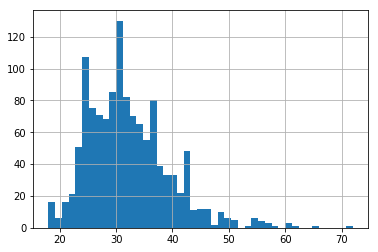

In [814]:
#Check distribution of ages
df['Age'].hist(bins  = 45)

In [815]:
#Column values
country_list = df['Country']
region_list = df['US_Region']

#Gender is a freeform field so need to account for typos and different spellings
gender_list = df['Gender']
#set(gender_list)

In [816]:
#Focusing on two tech-hub cities: NY & CA
region_list_binned = [x if x in ['NY','CA'] else "Other" for x in region_list]

In [817]:
#As there are other genders in the survey and we are concerned with male & female, the others will be binned
def val_changer(y):
    for x in y:
        if x in ['Male','Mail','M','Male ','Man','Malr','maile','male','msle']:
            x = 'Male'
        elif x in ['F','Female','Femake','Female ','femail','female','f']:
            x = 'Female'
        else:
            x = 'Other'
        return x

gender_list_binned = gender_list.apply(val_changer)

In [818]:
#List of unique countries included in the survey
#set(country_list)

#List of continents for binning
europe = ['Austria','Belgium','Bulgaria','Boznia and Herzegovina','Croatia','Czeh Republic','Denmark','Finland','France','Germany','Greece','Hungary','Ireland','Italy','Latvia','Moldova','Netherlands','Poland','Portugal','Poland','Romania','Slovenia','Spain','Sweden','United Kingdom','Russia','Norway','Switzerland']
asia = ['China','India','Japan','Philippines','Singapore','Thailand','Georgia']
south_america = ['Brazil','Colombia','Costa Rica','Uruguay']
africa = ['South Africa','Zimbabwe','Nigera']
oceania = ['New Zealand','Australia']

In [819]:
def country_bin(x):
    if x['Country'] == 'United States':
        x = 'United States'
    elif x['Country'] in europe:
        x = 'Europe'
    elif x['Country'] in asia:
        x = 'Asia'
    elif x['Country'] in south_america:
        x = 'South America'
    elif x['Country'] in oceania:
        x = 'Oceania'
    elif x['Country'] in africa:
        x = 'Africa'
    elif x['Country'] == 'Mexico':
        x = 'Mexico'
    elif x['Country'] == 'Canada':
        x = 'Canada'
    else:
        x = 'The Bahamas'
    return x

df['Country'] = df.apply(country_bin, axis = 1)

In [820]:
#Bin Ages
def age_bin(x):
        if x['Age'] <= 30:
            x = 1
        elif x['Age'] > 30:
            x = 0
        return x

df['Age'] = df.apply(age_bin, axis = 1)

In [821]:
#Convert DV columns into binomial format
#DV 1 - Bin yes and some of them to 1, no 0
def supervisor_dv(x):
    if x['Would you be willing to discuss a mental health issue with your direct supervisor(s)?'] == 'Yes' or x['Would you be willing to discuss a mental health issue with your direct supervisor(s)?'] == 'Some of them':
        val = 1
    else:
        val = 0    
    return val 

#DV 2 - Bin yes and maybe to 1, no 0
def neg_consq(x):
    if x['Do you think that discussing a mental health issue with your employer would have negative consequences?'] == 'Yes' or x['Do you think that discussing a mental health issue with your employer would have negative consequences?'] == 'Maybe':
        val = 1
    else:
        val = 0
    return val

In [822]:
#Create DVs
df['mh_issue_supervisor'] = df.apply(supervisor_dv, axis = 1)
df['mh_issue_neg_consq'] = df.apply(neg_consq, axis = 1)

In [823]:
#Drop old values and replace df with new ones for country and us region
df.drop(['US_Region','Gender'], axis = 1, inplace = True)
df['US_Region'] = region_list_binned
df['Gender'] = gender_list_binned

In [824]:
#Use 'other' gender as a filter for the DF
df = df[df.Gender != 'Other']

In [825]:
#Create dummy variables 
df2 = pd.get_dummies(df)

In [826]:
                                ### Begin Stepwise Logistic Models ###

In [827]:
#Create sets of independent variables
x_main = df2['Is your employer primarily a tech company/organization?_Yes']
x_main_demog = df2[['Have you sought treatment for a mental health condition?_Yes','Is your employer primarily a tech company/organization?_Yes', 'Age','Gender_Male','Country_United States','Country_Mexico','Country_Africa','Country_Canada','Country_Oceania','Country_Asia','Country_South America','Country_The Bahamas','Do you have a family history of mental illness?_Yes']]
x_main_demog_work = df2[['Have you sought treatment for a mental health condition?_Yes','Is your employer primarily a tech company/organization?_Yes', 'Age','Gender_Male','Country_United States','Country_Mexico','Country_Africa','Country_Canada','Country_Oceania','Country_Asia','Country_South America','Country_The Bahamas','Do you have a family history of mental illness?_Yes','Are you self-employed?_Yes','Do you work remotely (outside of an office) at least 50% of the time?_Yes']]
x_main_demog_work_employer = df2[['Have you sought treatment for a mental health condition?_Yes','Is your employer primarily a tech company/organization?_Yes', 'Age','Gender_Male','Country_United States','Country_Mexico','Country_Africa','Country_Canada','Country_Oceania','Country_Asia','Country_South America','Country_The Bahamas','Do you have a family history of mental illness?_Yes','Are you self-employed?_Yes','Do you work remotely (outside of an office) at least 50% of the time?_Yes','How many employees does your company or organization have?_100-500','How many employees does your company or organization have?_26-100','How many employees does your company or organization have?_500-1000','How many employees does your company or organization have?_6-25','How many employees does your company or organization have?_More than 1000',"Does your employer provide mental health benefits?_Don't know",'Does your employer provide mental health benefits?_Yes',"Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?_Don't know", 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?_Yes','How easy is it for you to take medical leave for a mental health condition?_Somewhat difficult','How easy is it for you to take medical leave for a mental health condition?_Somewhat easy','How easy is it for you to take medical leave for a mental health condition?_Very difficult','How easy is it for you to take medical leave for a mental health condition?_Very easy']]

#Create sets of dependent variables
y_supervisor = df['mh_issue_supervisor']
y_consq = df['mh_issue_neg_consq']

In [828]:
                                ### Starting with First Dependent Variable ###                                
                            ### First Logit Model Using Main Independent Variable ###                          

In [829]:
#Logit 1a, 1b
logit_sup = sm.Logit(y_supervisor, x_main).fit()
logit_sup.summary()

Optimization terminated successfully.
         Current function value: 0.631812
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     mh_issue_supervisor   No. Observations:                  987
Model:                           Logit   Df Residuals:                      986
Method:                            MLE   Df Model:                            0
Date:                 Fri, 10 Apr 2020   Pseudo R-squ.:                -0.01395
Time:                         17:02:25   Log-Likelihood:                -623.60
converged:                        True   LL-Null:                       -615.02
                                         LLR p-value:                       nan
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Is your employer primarily a tech company/organization?_Yes     0.8047      0.076     10.576      0.000       0.656       0.954
===============================================================================================================================
"""

In [830]:
logit_sup.aic

1249.1974741614558

In [831]:
                         ### Second Logit Model Adding in Demographic Level Variables ###

In [832]:
#Logit 2a, 2b
logit_sup_2 = sm.Logit(y_supervisor, x_main_demog).fit()
logit_sup_2.summary()

         Current function value: 0.619019
         Iterations: 35


/Users/joevorbeck/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     mh_issue_supervisor   No. Observations:                  987
Model:                           Logit   Df Residuals:                      974
Method:                            MLE   Df Model:                           12
Date:                 Fri, 10 Apr 2020   Pseudo R-squ.:                0.006578
Time:                         17:02:25   Log-Likelihood:                -610.97
converged:                       False   LL-Null:                       -615.02
                                         LLR p-value:                    0.7780
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Have you sought treatment for a mental health condition?_Yes     0.0211      0.145      0.145      0.884      -0.264       0.306
Is your employer primarily a tech company/organization?_Yes      0.3247      0.151      2.156      0.031       0.030       0.620
Age                                                              0.0762      0.133      0.573      0.567      -0.185       0.337
Gender_Male                                                      0.3608      0.135      2.663      0.008       0.095       0.626
Country_United States                                            0.1932      0.144      1.341      0.180      -0.089       0.476
Country_Mexico                                                  16.5261   5463.356      0.003      0.998   -1.07e+04    1.07e+04
Country_Africa                                                  30.3308   2.28e+06   1.33e-05      1.000   -4.48e+06    4.48e+06
Country_Canada                                                   0.3631      0.318      1.141      0.254      -0.261       0.987
Country_Oceania                                                 -0.2131      0.428     -0.498      0.619      -1.052       0.626
Country_Asia                                                    -0.7948      0.536     -1.484      0.138      -1.845       0.255
Country_South America                                            0.4880      0.815      0.599      0.549      -1.109       2.085
Country_The Bahamas                                             -0.1803      0.747     -0.241      0.809      -1.645       1.284
Do you have a family history of mental illness?_Yes              0.0715      0.151      0.473      0.636      -0.225       0.368
================================================================================================================================
"""

In [833]:
logit_sup_2.aic

1247.9438295665832

In [834]:
                        ### Third Logit Model Adding in Work Level Variables ###

In [835]:
logit_sup_3 = sm.Logit(y_supervisor, x_main_demog_work).fit()
logit_sup_3.summary()

         Current function value: 0.618537
         Iterations: 35


/Users/joevorbeck/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     mh_issue_supervisor   No. Observations:                  987
Model:                           Logit   Df Residuals:                      972
Method:                            MLE   Df Model:                           14
Date:                 Fri, 10 Apr 2020   Pseudo R-squ.:                0.007352
Time:                         17:02:25   Log-Likelihood:                -610.50
converged:                       False   LL-Null:                       -615.02
                                         LLR p-value:                    0.8283
=============================================================================================================================================
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Have you sought treatment for a mental health condition?_Yes                  0.0205      0.146      0.140      0.888      -0.265       0.306
Is your employer primarily a tech company/organization?_Yes                   0.3282      0.155      2.119      0.034       0.025       0.632
Age                                                                           0.0724      0.134      0.541      0.589      -0.190       0.335
Gender_Male                                                                   0.3569      0.136      2.617      0.009       0.090       0.624
Country_United States                                                         0.2248      0.148      1.520      0.128      -0.065       0.515
Country_Mexico                                                               16.4487   5457.575      0.003      0.998   -1.07e+04    1.07e+04
Country_Africa                                                               30.6954   2.72e+06   1.13e-05      1.000   -5.33e+06    5.33e+06
Country_Canada                                                                0.3766      0.319      1.180      0.238      -0.249       1.002
Country_Oceania                                                              -0.1753      0.430     -0.407      0.684      -1.018       0.668
Country_Asia                                                                 -0.8136      0.536     -1.519      0.129      -1.864       0.237
Country_South America                                                         0.4913      0.816      0.602      0.547      -1.108       2.091
Country_The Bahamas                                                          -0.1601      0.748     -0.214      0.830      -1.625       1.305
Do you have a family history of mental illness?_Yes                           0.0676      0.152      0.446      0.655      -0.229       0.365
Are you self-employed?_Yes                                                    0.1982      0.252      0.786      0.432      -0.296       0.692
Do you work remotely (outside of an office) at least 50% of the time?_Yes    -0.1225      0.160     -0.766      0.444      -0.436       0.191
=============================================================================================================================================
"""

In [836]:
logit_sup_3.aic

1250.991489001419

In [837]:
                    ### Fourth Logit Model Adding in Employer Level Variables ###

In [838]:
logit_sup_4 = sm.Logit(y_supervisor, x_main_demog_work_employer).fit()
logit_sup_4.summary()

         Current function value: 0.561882
         Iterations: 35


/Users/joevorbeck/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     mh_issue_supervisor   No. Observations:                  987
Model:                           Logit   Df Residuals:                      959
Method:                            MLE   Df Model:                           27
Date:                 Fri, 10 Apr 2020   Pseudo R-squ.:                 0.09827
Time:                         17:02:26   Log-Likelihood:                -554.58
converged:                       False   LL-Null:                       -615.02
                                         LLR p-value:                 7.642e-14
===================================================================================================================================================================================================
                                                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Have you sought treatment for a mental health condition?_Yes                                                                       -0.1058      0.164     -0.643      0.520      -0.428       0.217
Is your employer primarily a tech company/organization?_Yes                                                                        -0.0103      0.186     -0.055      0.956      -0.376       0.355
Age                                                                                                                                -0.0682      0.150     -0.454      0.650      -0.363       0.227
Gender_Male                                                                                                                         0.1245      0.169      0.735      0.462      -0.208       0.457
Country_United States                                                                                                               0.0978      0.195      0.501      0.616      -0.285       0.480
Country_Mexico                                                                                                                     17.3794   5558.839      0.003      0.998   -1.09e+04    1.09e+04
Country_Africa                                                                                                                     23.4399   7.98e+04      0.000      1.000   -1.56e+05    1.56e+05
Country_Canada                                                                                                                      0.2689      0.348      0.772      0.440      -0.414       0.952
Country_Oceania                                                                                                                    -0.2836      0.482     -0.588      0.556      -1.229       0.662
Country_Asia                                                                                                                       -0.7645      0.594     -1.288      0.198      -1.928       0.399
Country_South America                                                                                                               0.7451      0.860      0.867      0.386      -0.940       2.430
Country_The Bahamas                                                                                                                -0.3462      0.816     -0.424      0.671      -1.946       1.253
Do you have a family history of mental illness?_Yes                                                                                 0.0241      0.163      0.148      0.882      -0.295       0.343
Are you self-employed?_Yes                                                                      

In [839]:
logit_sup_4.aic

1165.1552887346725

In [840]:
                                    ### Second Dependent Variable ###
                            ### First Logit Model Using Main Indepdent Variable ### 

In [841]:
logit_consq = sm.Logit(y_consq, x_main).fit()
logit_consq.summary()

Optimization terminated successfully.
         Current function value: 0.681337
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     mh_issue_neg_consq   No. Observations:                  987
Model:                          Logit   Df Residuals:                      986
Method:                           MLE   Df Model:                            0
Date:                Fri, 10 Apr 2020   Pseudo R-squ.:                -0.01878
Time:                        17:02:26   Log-Likelihood:                -672.48
converged:                       True   LL-Null:                       -660.09
                                        LLR p-value:                       nan
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Is your employer primarily a tech company/organization?_Yes     0.3420      0.071      4.793      0.000       0.202       0.482
===============================================================================================================================
"""

In [842]:
logit_consq.aic

1346.9601070713381

In [843]:
                    ### Second Logit Model Adding in Demographic Level Variables ###

In [844]:
logit_consq_2 = sm.Logit(y_consq, x_main_demog).fit()
logit_consq_2.summary()

         Current function value: 0.653017
         Iterations: 35


/Users/joevorbeck/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     mh_issue_neg_consq   No. Observations:                  987
Model:                          Logit   Df Residuals:                      974
Method:                           MLE   Df Model:                           12
Date:                Fri, 10 Apr 2020   Pseudo R-squ.:                 0.02357
Time:                        17:02:26   Log-Likelihood:                -644.53
converged:                      False   LL-Null:                       -660.09
                                        LLR p-value:                  0.001891
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Have you sought treatment for a mental health condition?_Yes     0.4678      0.139      3.364      0.001       0.195       0.740
Is your employer primarily a tech company/organization?_Yes     -0.1768      0.150     -1.182      0.237      -0.470       0.116
Age                                                             -0.0584      0.128     -0.456      0.648      -0.310       0.193
Gender_Male                                                     -0.0449      0.135     -0.334      0.739      -0.309       0.219
Country_United States                                            0.2580      0.140      1.848      0.065      -0.016       0.532
Country_Mexico                                                 -17.0044   5503.047     -0.003      0.998   -1.08e+04    1.08e+04
Country_Africa                                                  -0.7999      0.947     -0.844      0.399      -2.657       1.057
Country_Canada                                                   0.0733      0.294      0.249      0.803      -0.503       0.650
Country_Oceania                                                  0.2242      0.432      0.520      0.603      -0.621       1.070
Country_Asia                                                     1.5189      0.660      2.301      0.021       0.225       2.813
Country_South America                                           -0.1549      0.693     -0.224      0.823      -1.513       1.203
Country_The Bahamas                                              1.1987      0.832      1.440      0.150      -0.432       2.830
Do you have a family history of mental illness?_Yes              0.4161      0.146      2.841      0.004       0.129       0.703
================================================================================================================================
"""

In [845]:
logit_consq_2.aic

1315.0552125890777

In [846]:
                        ### Third Logit Model Adding in Work Level Variables ###

In [847]:
logit_consq_3 = sm.Logit(y_consq, x_main_demog_work).fit()
logit_consq_3.summary()

         Current function value: 0.652260
         Iterations: 35


/Users/joevorbeck/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     mh_issue_neg_consq   No. Observations:                  987
Model:                          Logit   Df Residuals:                      972
Method:                           MLE   Df Model:                           14
Date:                Fri, 10 Apr 2020   Pseudo R-squ.:                 0.02470
Time:                        17:02:26   Log-Likelihood:                -643.78
converged:                      False   LL-Null:                       -660.09
                                        LLR p-value:                  0.003278
=============================================================================================================================================
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------
Have you sought treatment for a mental health condition?_Yes                  0.4744      0.139      3.403      0.001       0.201       0.748
Is your employer primarily a tech company/organization?_Yes                  -0.1571      0.154     -1.022      0.307      -0.458       0.144
Age                                                                          -0.0642      0.129     -0.497      0.619      -0.317       0.189
Gender_Male                                                                  -0.0330      0.135     -0.244      0.807      -0.298       0.232
Country_United States                                                         0.2254      0.143      1.573      0.116      -0.055       0.506
Country_Mexico                                                              -16.8076   5487.413     -0.003      0.998   -1.08e+04    1.07e+04
Country_Africa                                                               -0.7906      0.945     -0.837      0.403      -2.642       1.061
Country_Canada                                                                0.0663      0.295      0.225      0.822      -0.512       0.644
Country_Oceania                                                               0.1939      0.434      0.447      0.655      -0.656       1.044
Country_Asia                                                                  1.5492      0.662      2.342      0.019       0.253       2.846
Country_South America                                                        -0.1429      0.693     -0.206      0.837      -1.502       1.216
Country_The Bahamas                                                           1.1663      0.833      1.400      0.161      -0.466       2.799
Do you have a family history of mental illness?_Yes                           0.4242      0.147      2.890      0.004       0.136       0.712
Are you self-employed?_Yes                                                   -0.2879      0.236     -1.222      0.222      -0.750       0.174
Do you work remotely (outside of an office) at least 50% of the time?_Yes     0.0651      0.155      0.418      0.676      -0.240       0.370
=============================================================================================================================================
"""

In [848]:
logit_consq_3.aic

1317.560894474907

In [849]:
                  ### Fourth Logit Model Adding in Employer Level Variables ###

In [850]:
logit_consq_4 = sm.Logit(y_consq, x_main_demog_work_employer).fit()
logit_consq_4.summary()

         Current function value: 0.580153
         Iterations: 35


/Users/joevorbeck/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     mh_issue_neg_consq   No. Observations:                  987
Model:                          Logit   Df Residuals:                      959
Method:                           MLE   Df Model:                           27
Date:                Fri, 10 Apr 2020   Pseudo R-squ.:                  0.1325
Time:                        17:02:26   Log-Likelihood:                -572.61
converged:                      False   LL-Null:                       -660.09
                                        LLR p-value:                 1.308e-23
===================================================================================================================================================================================================
                                                                                                                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Have you sought treatment for a mental health condition?_Yes                                                                        0.4669      0.160      2.916      0.004       0.153       0.781
Is your employer primarily a tech company/organization?_Yes                                                                        -0.2500      0.191     -1.309      0.190      -0.624       0.124
Age                                                                                                                                -0.1079      0.147     -0.732      0.464      -0.397       0.181
Gender_Male                                                                                                                        -0.1519      0.171     -0.887      0.375      -0.487       0.184
Country_United States                                                                                                              -0.0992      0.190     -0.522      0.602      -0.472       0.274
Country_Mexico                                                                                                                    -18.1806   5614.605     -0.003      0.997    -1.1e+04     1.1e+04
Country_Africa                                                                                                                     -0.8757      0.955     -0.917      0.359      -2.747       0.995
Country_Canada                                                                                                                     -0.2585      0.334     -0.773      0.439      -0.914       0.397
Country_Oceania                                                                                                                    -0.0460      0.488     -0.094      0.925      -1.002       0.910
Country_Asia                                                                                                                        1.4430      0.737      1.959      0.050      -0.001       2.887
Country_South America                                                                                                              -0.5488      0.726     -0.756      0.449      -1.971       0.873
Country_The Bahamas                                                                                                                 1.2782      0.957      1.335      0.182      -0.598       3.154
Do you have a family history of mental illness?_Yes                                                                                 0.4050      0.160      2.523      0.012       0.090       0.720
Are you self-employed?_Yes                                                                               

In [851]:
logit_consq_4.aic

1201.2215212093238